GPU configured successfully
Turn Analysis Summary:
total_turns: 314
left_turns: 146
right_turns: 168
turn_segments: 629


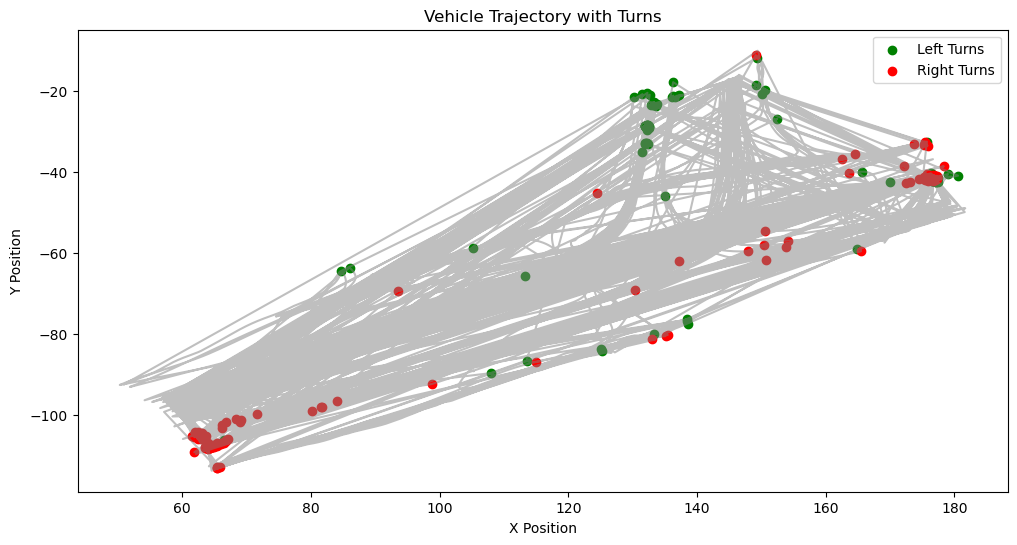

In [1]:
from gpu_config import configure_gpu
configure_gpu()

import pandas as pd
import numpy as np

def label_turns(df, heading_column='heading', turn_threshold=10):
    # Calculate heading change between consecutive frames
    df['heading_change'] = df[heading_column].diff().abs()
    
    # Initialize turn labeling
    df['turn_label'] = 'straight'
    
    # Identify turns
    left_turn_mask = (df['heading_change'] > turn_threshold) & (df[heading_column].diff() > 0)
    right_turn_mask = (df['heading_change'] > turn_threshold) & (df[heading_column].diff() < 0)
    
    df.loc[left_turn_mask, 'turn_label'] = 'left_turn'
    df.loc[right_turn_mask, 'turn_label'] = 'right_turn'
    
    # Optionally, create a continuous turn segment
    df['in_turn'] = df['turn_label'].isin(['left_turn', 'right_turn'])
    
    # Group consecutive turn segments
    df['turn_segment'] = (df['in_turn'] != df['in_turn'].shift()).cumsum()
    
    return df

def analyze_turns(df):

    turn_summary = {
        'total_turns': df[df['turn_label'] != 'straight'].shape[0],
        'left_turns': df[df['turn_label'] == 'left_turn'].shape[0],
        'right_turns': df[df['turn_label'] == 'right_turn'].shape[0],
        'turn_segments': df['turn_segment'].max()
    }
    
    return turn_summary



# Read the CSV file
df = pd.read_csv('./Tracks/00_tracks.csv')

# Label turns
df_with_turns = label_turns(df)

# Analyze turns
turn_analysis = analyze_turns(df_with_turns)

# Print turn summary
print("Turn Analysis Summary:")
for key, value in turn_analysis.items():
    print(f"{key}: {value}")

# Optional: Visualize turns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_with_turns['xCenter'], df_with_turns['yCenter'], c='gray', alpha=0.5)

turn_points = df_with_turns[df_with_turns['turn_label'] != 'straight']
left_turns = turn_points[turn_points['turn_label'] == 'left_turn']
right_turns = turn_points[turn_points['turn_label'] == 'right_turn']

plt.scatter(left_turns['xCenter'], left_turns['yCenter'], c='green', label='Left Turns')
plt.scatter(right_turns['xCenter'], right_turns['yCenter'], c='red', label='Right Turns')

plt.title('Vehicle Trajectory with Turns')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()





In [2]:
import pandas as pd
import numpy as np
import glob
import os
from tqdm import tqdm

def process_trajectory_files(data_dir='Tracks/', heading_threshold=10):
    """
    Process all trajectory CSV files in the specified directory
    
    Parameters:
    -----------
    data_dir : str
        Directory containing the trajectory CSV files
    heading_threshold : float
        Threshold for heading change to be considered a turn
        
    Returns:
    --------
    pd.DataFrame
        Processed and labeled dataset
    """
    # Get all CSV files
    csv_files = glob.glob(os.path.join(data_dir, '*tracks.csv'))
    print(f"Found {len(csv_files)} CSV files")
    
    # Initialize list to store dataframes
    dfs = []
    
    # Process each file
    for file_path in tqdm(csv_files, desc="Processing files"):
        # Read CSV
        df = pd.read_csv(file_path)
        
        # Add file identifier
        df['file_id'] = os.path.basename(file_path).split('.')[0]
        
        # Calculate heading change
        df['heading_change'] = df['heading'].diff()
        
        # Label turns
        df['turn_label'] = 'straight'
        heading_change = df['heading_change'].fillna(0)
        
        # Identify turns
        left_mask = (heading_change > heading_threshold)
        right_mask = (heading_change < -heading_threshold)
        
        df.loc[left_mask, 'turn_label'] = 'left_turn'
        df.loc[right_mask, 'turn_label'] = 'right_turn'
        
        # Add binary turn label
        df['turn_binary'] = (df['turn_label'] != 'straight').astype(np.int8)
        
        # Store processed dataframe
        dfs.append(df)
    
    # Combine all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Print statistics
    print("\nDataset Statistics:")
    print(f"Total records: {len(combined_df)}")
    print("\nTurn distribution:")
    print(combined_df['turn_label'].value_counts(normalize=True))
    print("\nFiles processed:")
    print(combined_df['file_id'].value_counts())
    
    return combined_df

def save_processed_data(df, output_path='processed_trajectory_data.csv'):
    """
    Save the processed dataset
    
    Parameters:
    -----------
    df : pd.DataFrame
        Processed dataset to save
    output_path : str
        Path where to save the CSV file
    """
    df.to_csv(output_path, index=False)
    print(f"\nProcessed data saved to: {output_path}")
    

# Process all trajectory files
processed_df = process_trajectory_files()

# Save processed dataset
save_processed_data(processed_df)

# Print memory usage
memory_usage = processed_df.memory_usage(deep=True).sum() / 1024**2
print(f"\nTotal memory usage: {memory_usage:.2f} MB")


Found 34 CSV files


Processing files: 100%|██████████| 34/34 [00:10<00:00,  3.22it/s]



Dataset Statistics:
Total records: 15220838

Turn distribution:
turn_label
straight      0.999111
left_turn     0.000463
right_turn    0.000426
Name: proportion, dtype: float64

Files processed:
file_id
27_tracks         1059267
29_tracks         1045829
labeled_tracks    1045654
28_tracks          939476
26_tracks          885145
21_tracks          796178
23_tracks          782772
22_tracks          753743
25_tracks          672514
20_tracks          634916
18_tracks          625989
24_tracks          580827
19_tracks          492008
16_tracks          352183
32_tracks          326394
17_tracks          325905
31_tracks          290309
30_tracks          287010
12_tracks          284044
13_tracks          276560
08_tracks          260348
15_tracks          254543
02_tracks          247649
14_tracks          231445
00_tracks          205275
06_tracks          204465
11_tracks          202702
07_tracks          201296
01_tracks          193248
10_tracks          180652
03_tracks       

/var/folders/37/0k0dl4hj36jg21mcy4dbw89w0000gn/T/ipykernel_52036/1255667251.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Dataset Overview:
--------------------------------------------------
Total records: 15,220,838
Number of features: 22

Features: recordingId, trackId, frame, trackLifetime, xCenter, yCenter, heading, width, length, xVelocity, yVelocity, xAcceleration, yAcceleration, lonVelocity, latVelocity, lonAcceleration, latAcceleration, file_id, heading_change, turn_label, turn_binary, stop_before_pedestrian

Basic Statistics:
--------------------------------------------------
        recordingId       trackId         frame  trackLifetime       xCenter  \
count  1.522084e+07  1.522084e+07  1.522084e+07   1.522084e+07  1.522084e+07   
mean   2.100819e+01  1.082531e+02  1.466739e+04   8.813412e+03  6.121917e+01   
std    8.149944e+00  1.450409e+02  8.706880e+03   9.614351e+03  3.419954e+01   
min    0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00  5.221060e+00   
25%    1.700000e+01  1.100000e+01  7.183000e+03   3.370000e+02  3.438498e+01   
50%    2.300000e+01  2.200000e+01  1.447700e+04   

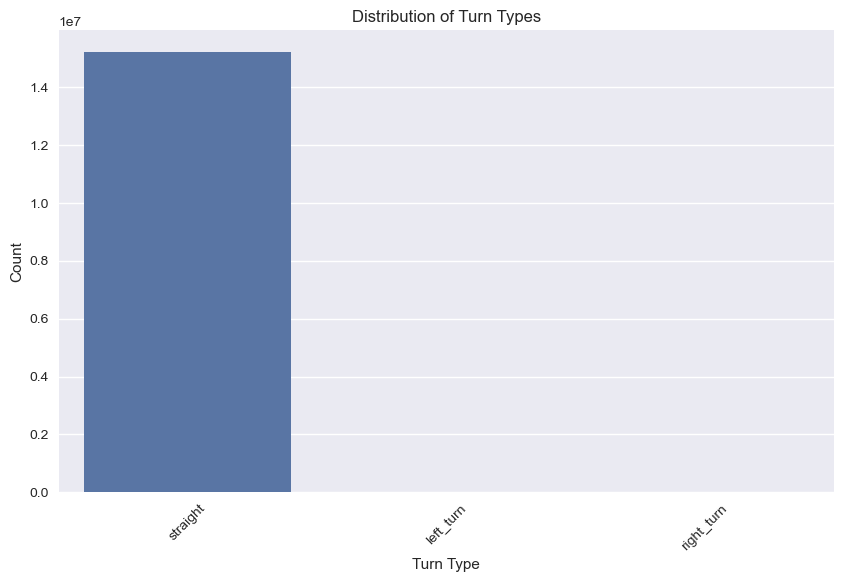

<Figure size 1200x600 with 0 Axes>

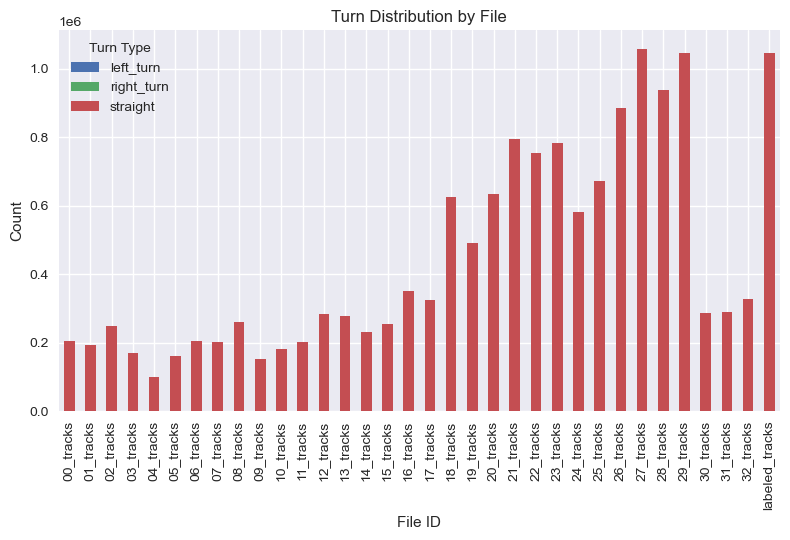

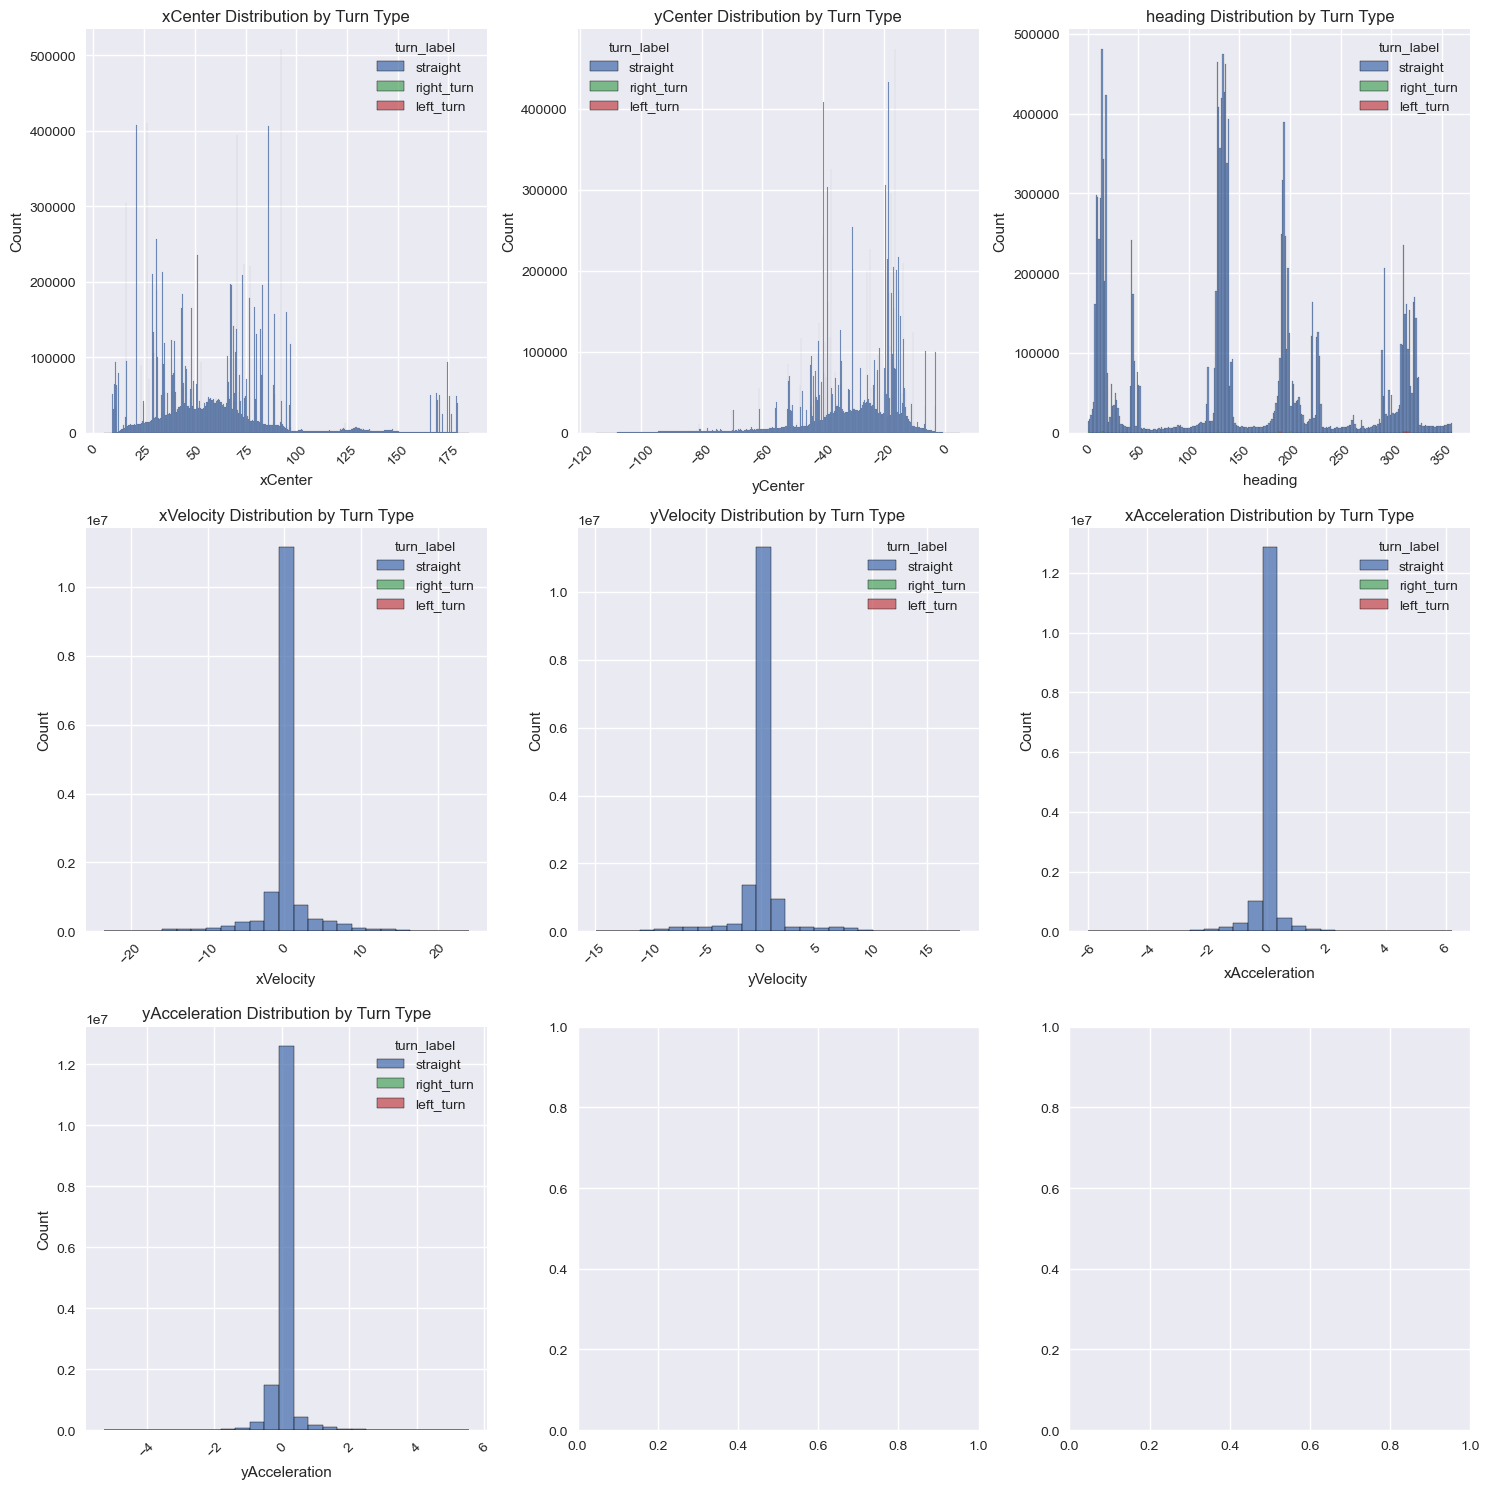

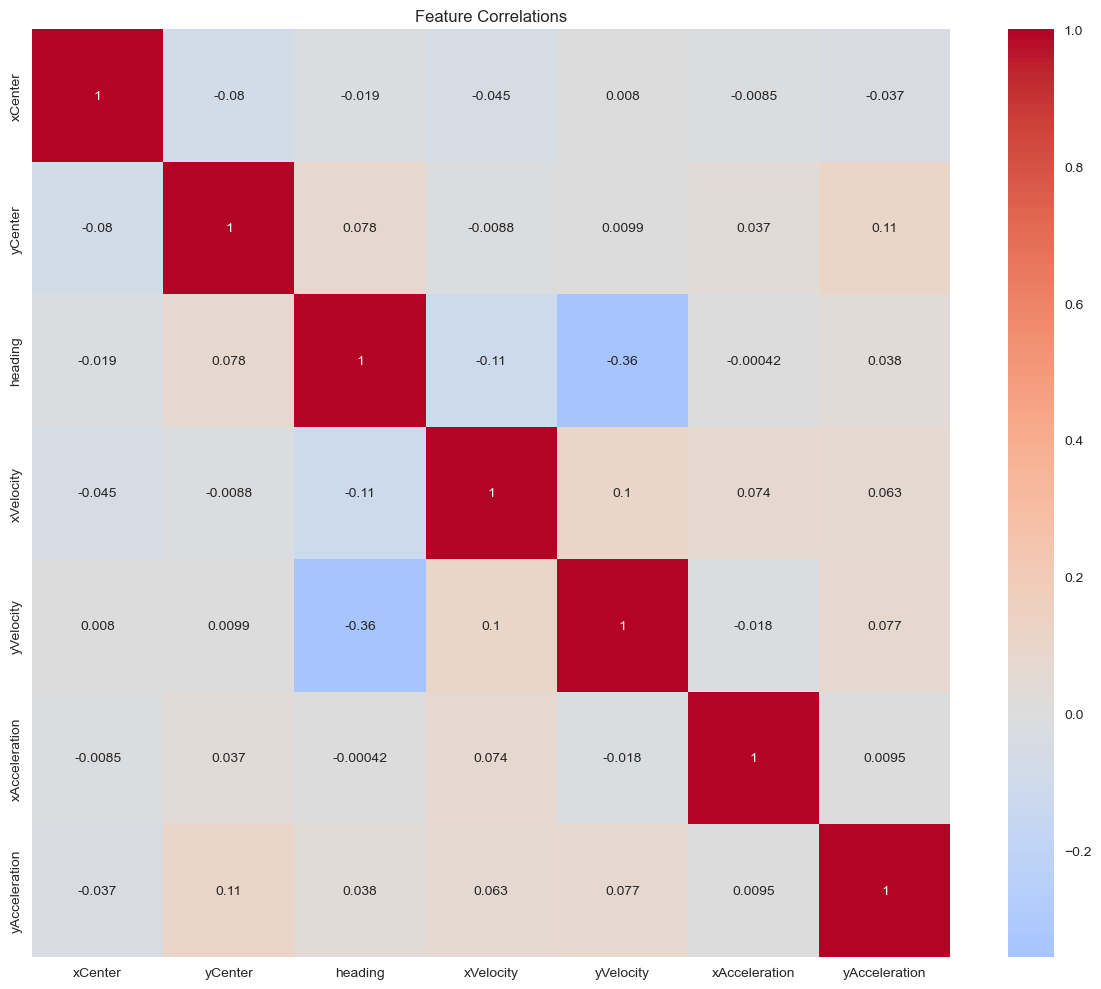

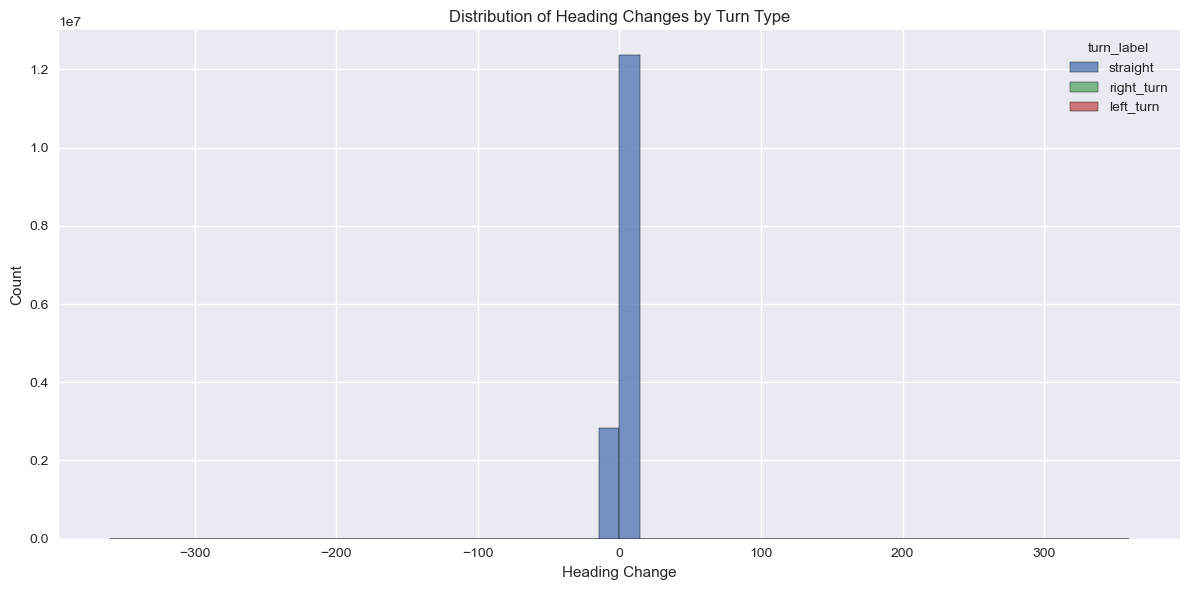

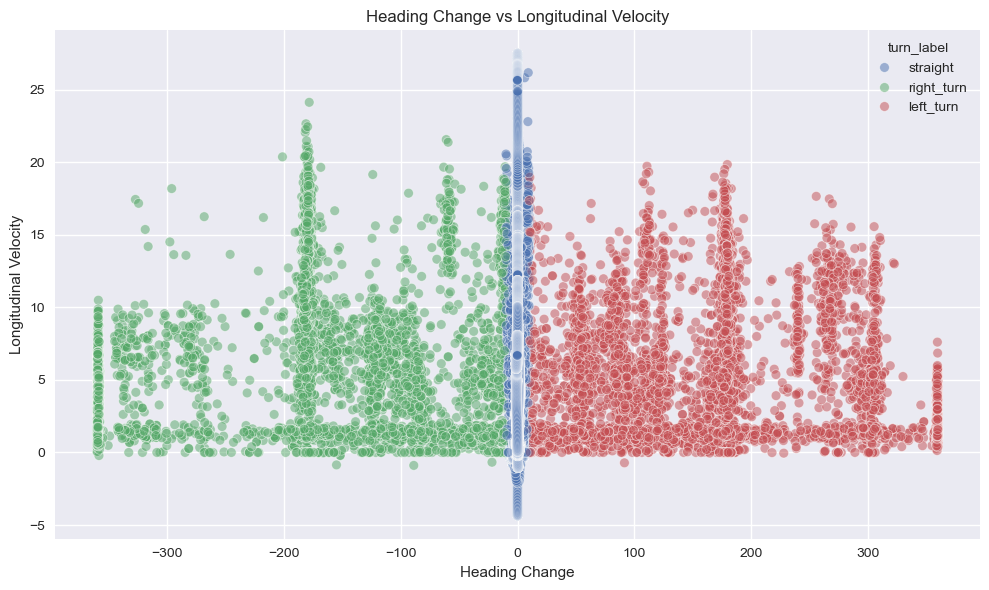

<Figure size 1200x600 with 0 Axes>

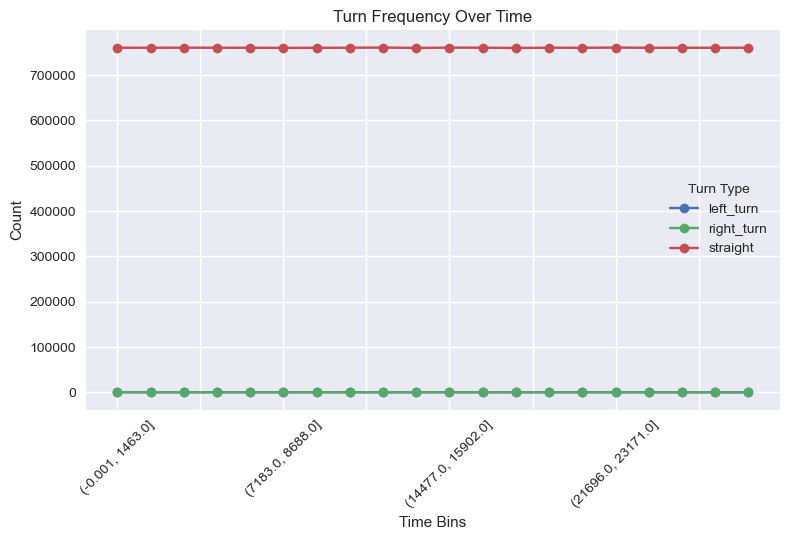


Summary Report:

1. Basic Statistics
------------------------------
Dataset Overview:
--------------------------------------------------
Total records: 15,220,838
Number of features: 23

Features: recordingId, trackId, frame, trackLifetime, xCenter, yCenter, heading, width, length, xVelocity, yVelocity, xAcceleration, yAcceleration, lonVelocity, latVelocity, lonAcceleration, latAcceleration, file_id, heading_change, turn_label, turn_binary, stop_before_pedestrian, frame_binned

Basic Statistics:
--------------------------------------------------
        recordingId       trackId         frame  trackLifetime       xCenter  \
count  1.522084e+07  1.522084e+07  1.522084e+07   1.522084e+07  1.522084e+07   
mean   2.100819e+01  1.082531e+02  1.466739e+04   8.813412e+03  6.121917e+01   
std    8.149944e+00  1.450409e+02  8.706880e+03   9.614351e+03  3.419954e+01   
min    0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00  5.221060e+00   
25%    1.700000e+01  1.100000e+01  7.183000e+03

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

class TrajectoryEDA:
    def __init__(self, data_path):
        """Initialize EDA with processed trajectory data"""
        self.df = pd.read_csv(data_path)
        plt.style.use('seaborn')
        
    def analyze_basic_statistics(self):
        """Analyze basic statistics of the dataset"""
        print("Dataset Overview:")
        print("-" * 50)
        print(f"Total records: {len(self.df):,}")
        print(f"Number of features: {len(self.df.columns)}")
        print("\nFeatures:", ', '.join(self.df.columns))
        
        print("\nBasic Statistics:")
        print("-" * 50)
        print(self.df.describe())
        
        print("\nMissing Values:")
        print("-" * 50)
        missing = self.df.isnull().sum()
        print(missing[missing > 0])
        
    def analyze_turn_distribution(self):
        """Analyze turn distribution and patterns"""
        print("\nTurn Distribution:")
        print("-" * 50)
        turn_dist = self.df['turn_label'].value_counts()
        print(turn_dist)
        
        # Plot turn distribution
        plt.figure(figsize=(10, 6))
        sns.barplot(x=turn_dist.index, y=turn_dist.values)
        plt.title('Distribution of Turn Types')
        plt.xlabel('Turn Type')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()
        
        # Turn distribution by file
        plt.figure(figsize=(12, 6))
        turn_by_file = pd.crosstab(self.df['file_id'], self.df['turn_label'])
        turn_by_file.plot(kind='bar', stacked=True)
        plt.title('Turn Distribution by File')
        plt.xlabel('File ID')
        plt.ylabel('Count')
        plt.legend(title='Turn Type')
        plt.tight_layout()
        plt.show()
        
    def analyze_trajectory_characteristics(self):
        """Analyze trajectory characteristics"""
        features = ['xCenter', 'yCenter', 'heading', 'xVelocity', 'yVelocity', 
                   'xAcceleration', 'yAcceleration']
        
        # Distribution plots
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        axes = axes.ravel()
        
        for idx, feature in enumerate(features):
            sns.histplot(data=self.df, x=feature, hue='turn_label', 
                        multiple="stack", ax=axes[idx])
            axes[idx].set_title(f'{feature} Distribution by Turn Type')
            axes[idx].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Correlation analysis
        plt.figure(figsize=(12, 10))
        correlation = self.df[features].corr()
        sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlations')
        plt.tight_layout()
        plt.show()
        
    def analyze_heading_changes(self):
        """Analyze heading changes and turn patterns"""
        plt.figure(figsize=(12, 6))
        sns.histplot(data=self.df, x='heading_change', hue='turn_label',
                    multiple="stack", bins=50)
        plt.title('Distribution of Heading Changes by Turn Type')
        plt.xlabel('Heading Change')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
        
        # Heading change vs velocity
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=self.df, x='heading_change', y='lonVelocity',
                       hue='turn_label', alpha=0.5)
        plt.title('Heading Change vs Longitudinal Velocity')
        plt.xlabel('Heading Change')
        plt.ylabel('Longitudinal Velocity')
        plt.tight_layout()
        plt.show()
        
    def analyze_temporal_patterns(self):
        """Analyze temporal patterns in the data"""
        # Turn frequency over time
        self.df['frame_binned'] = pd.qcut(self.df['frame'], q=20)
        
        plt.figure(figsize=(12, 6))
        turn_over_time = pd.crosstab(self.df['frame_binned'], self.df['turn_label'])
        turn_over_time.plot(kind='line', marker='o')
        plt.title('Turn Frequency Over Time')
        plt.xlabel('Time Bins')
        plt.ylabel('Count')
        plt.legend(title='Turn Type')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    def generate_summary_report(self):
        """Generate a comprehensive summary report"""
        print("\nSummary Report:")
        print("=" * 50)
        
        # Basic statistics
        print("\n1. Basic Statistics")
        print("-" * 30)
        self.analyze_basic_statistics()
        
        # Turn patterns
        print("\n2. Turn Patterns")
        print("-" * 30)
        turn_stats = self.df.groupby('turn_label').agg({
            'heading_change': ['mean', 'std'],
            'lonVelocity': ['mean', 'std'],
            'latVelocity': ['mean', 'std']
        })
        print(turn_stats)
        
        # Feature importance
        print("\n3. Feature Importance for Turn Detection")
        print("-" * 30)
        for feature in ['heading_change', 'lonVelocity', 'latVelocity']:
            f_stat, p_val = stats.f_oneway(
                *[group[feature].values for name, group in self.df.groupby('turn_label')]
            )
            print(f"{feature:15} F-statistic: {f_stat:10.2f} p-value: {p_val:10.2e}")

def main():
    # Initialize EDA
    eda = TrajectoryEDA('processed_trajectory_data.csv')
    
    # Run analyses
    eda.analyze_basic_statistics()
    eda.analyze_turn_distribution()
    eda.analyze_trajectory_characteristics()
    eda.analyze_heading_changes()
    eda.analyze_temporal_patterns()
    eda.generate_summary_report()

if __name__ == "__main__":
    main()

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from scipy.signal import savgol_filter

class TrajectoryFeatureEngineering:
    def __init__(self, data_path):
        """Initialize feature engineering pipeline"""
        self.df = pd.read_csv(data_path)
        self.scaled_features = None
        
    def handle_infinite_values(self, df, replace_with=0):
        """Replace infinite values with specified value"""
        return df.replace([np.inf, -np.inf], replace_with)
        
    def create_kinematic_features(self):
        """Create features based on kinematic properties"""
        # Total velocity and acceleration
        self.df['total_velocity'] = np.sqrt(
            self.df['xVelocity']**2 + self.df['yVelocity']**2
        ).clip(0, 100)  # Clip to reasonable range
        
        self.df['total_acceleration'] = np.sqrt(
            self.df['xAcceleration']**2 + self.df['yAcceleration']**2
        ).clip(0, 50)  # Clip to reasonable range
        
        # Rate of heading change
        self.df['heading_change_rate'] = self.df.groupby('trackId')['heading_change'].transform(
            lambda x: x.diff()
        ).fillna(0).clip(-50, 50)  # Clip to reasonable range
        
        # Turning radius (avoid division by zero)
        heading_change_safe = np.where(
            np.abs(self.df['heading_change']) > 0.001,
            self.df['heading_change'],
            0.001
        )
        self.df['turning_radius'] = (
            self.df['total_velocity'] / np.abs(heading_change_safe)
        ).clip(0, 1000)  # Clip to reasonable range
        
    def create_trajectory_features(self):
        """Create features based on trajectory patterns"""
        # Path derivatives
        self.df['dx'] = self.df.groupby('trackId')['xCenter'].diff().fillna(0)
        self.df['dy'] = self.df.groupby('trackId')['yCenter'].diff().fillna(0)
        self.df['ddx'] = self.df.groupby('trackId')['dx'].diff().fillna(0)
        self.df['ddy'] = self.df.groupby('trackId')['dy'].diff().fillna(0)
        
        # Curvature (avoid division by zero)
        numerator = (self.df['dx']*self.df['ddy'] - self.df['dy']*self.df['ddx'])
        denominator = (self.df['dx']**2 + self.df['dy']**2)**(3/2)
        denominator = np.where(denominator > 0.001, denominator, 0.001)
        
        self.df['curvature'] = (
            np.abs(numerator / denominator)
        ).clip(0, 100)  # Clip to reasonable range
        
        # Angular velocity
        frame_diff = self.df.groupby('trackId')['frame'].diff().fillna(1)
        self.df['angular_velocity'] = (
            np.abs(self.df.groupby('trackId')['heading'].diff() / frame_diff)
        ).fillna(0).clip(0, 50)  # Clip to reasonable range
        
    def create_statistical_features(self, window_size=5):
        """Create statistical features using rolling windows"""
        # Group by trackId for rolling calculations
        grouped = self.df.groupby('trackId')
        
        # Rolling statistics for key features
        for feature in ['heading_change', 'total_velocity', 'angular_velocity']:
            # Rolling mean
            self.df[f'{feature}_mean'] = grouped[feature].transform(
                lambda x: x.rolling(window_size, center=True, min_periods=1).mean()
            ).fillna(0)
            
            # Rolling standard deviation
            self.df[f'{feature}_std'] = grouped[feature].transform(
                lambda x: x.rolling(window_size, center=True, min_periods=1).std()
            ).fillna(0)
            
            # Rolling max
            self.df[f'{feature}_max'] = grouped[feature].transform(
                lambda x: x.rolling(window_size, center=True, min_periods=1).max()
            ).fillna(0)
        
    def select_features(self):
        """Select relevant features for turn prediction"""
        features = [
            # Original kinematic features
            'heading', 'heading_change', 'lonVelocity', 'latVelocity',
            'lonAcceleration', 'latAcceleration',
            
            # New kinematic features
            'total_velocity', 'total_acceleration', 'heading_change_rate',
            'turning_radius', 'angular_velocity',
            
            # Trajectory features
            'curvature',
            
            # Statistical features
            'heading_change_mean', 'heading_change_std', 'heading_change_max',
            'total_velocity_mean', 'total_velocity_std', 'total_velocity_max',
            'angular_velocity_mean', 'angular_velocity_std', 'angular_velocity_max'
        ]
        
        selected_df = self.df[features]
        # Handle any remaining infinite values
        selected_df = self.handle_infinite_values(selected_df)
        # Ensure all values are finite and within float64 range
        selected_df = selected_df.clip(-1e300, 1e300)
        
        return selected_df
        
    def scale_features(self, features_df):
        """Scale features using RobustScaler"""
        scaler = RobustScaler()
        scaled_features = scaler.fit_transform(features_df)
        
        return pd.DataFrame(
            scaled_features,
            columns=features_df.columns
        )
        
    def process(self):
        """Run complete feature engineering pipeline"""
        print("Creating kinematic features...")
        self.create_kinematic_features()
        
        print("Creating trajectory features...")
        self.create_trajectory_features()
        
        print("Creating statistical features...")
        self.create_statistical_features()
        
        print("Selecting features...")
        selected_features = self.select_features()
        
        print("Scaling features...")
        scaled_features = self.scale_features(selected_features)
        
        # Add target variable
        scaled_features['turn_binary'] = self.df['turn_binary']
        
        # Final check for any remaining invalid values
        scaled_features = scaled_features.fillna(0)
        
        print("\nFeature Engineering Summary:")
        print("-" * 50)
        print(f"Original features: {len(self.df.columns)}")
        print(f"Engineered features: {len(scaled_features.columns)-1}")
        print("\nFeature list:")
        for feature in scaled_features.columns:
            if feature != 'turn_binary':
                print(f"- {feature}")
                
        return scaled_features

def main():
    # Initialize feature engineering
    fe = TrajectoryFeatureEngineering('processed_trajectory_data.csv')
    
    # Run feature engineering pipeline
    engineered_data = fe.process()
    
    # Save engineered features
    engineered_data.to_csv('engineered_features.csv', index=False)
    print("\nEngineered features saved to 'engineered_features.csv'")

if __name__ == "__main__":
    main()

Creating kinematic features...
Creating trajectory features...
Creating statistical features...
Selecting features...
Scaling features...

Feature Engineering Summary:
--------------------------------------------------
Original features: 41
Engineered features: 21

Feature list:
- heading
- heading_change
- lonVelocity
- latVelocity
- lonAcceleration
- latAcceleration
- total_velocity
- total_acceleration
- heading_change_rate
- turning_radius
- angular_velocity
- curvature
- heading_change_mean
- heading_change_std
- heading_change_max
- total_velocity_mean
- total_velocity_std
- total_velocity_max
- angular_velocity_mean
- angular_velocity_std
- angular_velocity_max

Engineered features saved to 'engineered_features.csv'


In [6]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
import xgboost as xgb
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import gc

class MemoryEfficientPipeline:
    def __init__(self, data_path, sequence_length=10, batch_size=1000):
        """Initialize pipeline with memory-efficient settings"""
        self.data_path = data_path
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.models = {}
        self.results = {}
        
        # Get data info without loading entire dataset
        temp_df = pd.read_csv(data_path, nrows=1)
        self.feature_columns = [col for col in temp_df.columns if col != 'turn_binary']
        self.n_features = len(self.feature_columns)
        del temp_df
    
    def data_generator(self, start_idx, end_idx):
        """Generate data in chunks"""
        chunks = pd.read_csv(
            self.data_path,
            skiprows=range(1, start_idx + 1),  # Skip header and rows before start
            nrows=end_idx - start_idx,
            chunksize=self.batch_size
        )
        
        for chunk in chunks:
            yield chunk
            
    def sequence_generator(self, start_idx, end_idx):
        """Memory-efficient sequence generation"""
        for chunk in self.data_generator(start_idx, end_idx):
            sequences = []
            labels = []
            
            # Create sequences from current chunk
            for i in range(len(chunk) - self.sequence_length):
                seq = chunk[self.feature_columns].iloc[i:(i + self.sequence_length)].values
                label = chunk['turn_binary'].iloc[i + self.sequence_length - 1]
                sequences.append(seq)
                labels.append(label)
            
            X_batch = np.array(sequences, dtype=np.float32)
            y_batch = np.array(labels, dtype=np.int8)
            
            yield X_batch, y_batch
            
            # Clear memory
            del sequences, labels, X_batch, y_batch
            gc.collect()

    def create_rnn_model(self, input_shape):
        """Create memory-efficient GRU model"""
        model = Sequential([
            GRU(32, input_shape=input_shape, return_sequences=True),  # Reduced from 64
            BatchNormalization(),
            Dropout(0.3),
            
            GRU(16, return_sequences=False),  # Removed one GRU layer
            BatchNormalization(),
            Dropout(0.3),
            
            Dense(8, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return model

    def train_models(self):
        """Train models with memory efficiency"""
        # Get total rows without loading entire dataset
        total_rows = sum(1 for _ in open(self.data_path)) - 1  # subtract header
        train_size = int(0.8 * total_rows)
        
        # Calculate class weights from a sample
        sample_df = pd.read_csv(self.data_path, nrows=100000)
        n_turns = sample_df['turn_binary'].sum()
        class_weight = {
            0: 1.0,
            1: len(sample_df) / (2 * n_turns)
        }
        del sample_df
        gc.collect()
        
        print(f"Total rows: {total_rows}")
        print(f"Class weights: {class_weight}")
        
        # Train GRU model
        print("\nTraining GRU model...")
        gru_model = self.create_rnn_model(
            input_shape=(self.sequence_length, self.n_features)
        )
        
        # Train using generators
        train_gen = self.sequence_generator(0, train_size)
        valid_gen = self.sequence_generator(train_size, total_rows)
        
        steps_per_epoch = (train_size - self.sequence_length) // self.batch_size
        validation_steps = (total_rows - train_size - self.sequence_length) // self.batch_size
        
        gru_model.fit(
            train_gen,
            steps_per_epoch=steps_per_epoch,
            validation_data=valid_gen,
            validation_steps=validation_steps,
            epochs=10,  # Reduced epochs
            class_weight=class_weight,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=3)
            ]
        )
        
        self.models['gru'] = gru_model
        
        # Train tree-based models on chunks
        print("\nTraining XGBoost model...")
        xgb_model = xgb.XGBClassifier(
            scale_pos_weight=class_weight[1],
            max_depth=6,
            learning_rate=0.1,
            n_estimators=100,
            use_label_encoder=False,
            eval_metric='logloss'
        )
        
        # Train on chunks
        for chunk in pd.read_csv(self.data_path, chunksize=self.batch_size):
            X_chunk = chunk[self.feature_columns]
            y_chunk = chunk['turn_binary']
            xgb_model.fit(
                X_chunk, y_chunk,
                xgb_model=None if not hasattr(xgb_model, 'get_booster') else xgb_model.get_booster()
            )
            del X_chunk, y_chunk
            gc.collect()
            
        self.models['xgb'] = xgb_model
        
        print("\nTraining LightGBM model...")
        lgb_model = LGBMClassifier(
            scale_pos_weight=class_weight[1],
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6
        )
        
        # Train on chunks
        for chunk in pd.read_csv(self.data_path, chunksize=self.batch_size):
            X_chunk = chunk[self.feature_columns]
            y_chunk = chunk['turn_binary']
            lgb_model.fit(
                X_chunk, y_chunk,
                init_model=None if not hasattr(lgb_model, 'booster_') else lgb_model.booster_
            )
            del X_chunk, y_chunk
            gc.collect()
            
        self.models['lgb'] = lgb_model

    def evaluate_models(self):
        """Evaluate models on test data chunks"""
        results = {model_name: {'y_true': [], 'y_pred': []} for model_name in self.models}
        
        # Evaluate on chunks
        test_gen = self.data_generator(int(0.8 * self.total_rows), self.total_rows)
        
        for chunk in test_gen:
            X_test = chunk[self.feature_columns]
            y_true = chunk['turn_binary']
            
            for model_name, model in self.models.items():
                if model_name == 'gru':
                    # Prepare sequences for GRU
                    X_seq = self.prepare_sequences(X_test)
                    y_pred = (model.predict(X_seq) > 0.5).astype(int)
                else:
                    y_pred = model.predict(X_test)
                
                results[model_name]['y_true'].extend(y_true)
                results[model_name]['y_pred'].extend(y_pred)
                
            gc.collect()
        
        # Print results
        for model_name in self.models:
            y_true = np.array(results[model_name]['y_true'])
            y_pred = np.array(results[model_name]['y_pred'])
            
            print(f"\n{model_name} Results:")
            print(classification_report(y_true, y_pred))
            
            cm = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'{model_name} Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
            plt.close()


pipeline = MemoryEfficientPipeline('engineered_features.csv', batch_size=1000)
pipeline.train_models()
pipeline.evaluate_models()

# Save best model
best_model = pipeline.models['gru']
best_model.save('best_model')


Total rows: 15220838
Class weights: {0: 1.0, 1: 16666.666666666668}

Training GRU model...
Epoch 1/10


2024-12-11 23:19:40.711061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-11 23:19:41.028905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-11 23:19:41.156531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


    1/12176 [..............................] - ETA: 6:11:27 - loss: 2.2824 - accuracy: 0.4899

2024-12-11 23:19:41.436151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-11 23:19:41.589550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  318/12176 [..............................] - ETA: 57:43 - loss: 1.5712 - accuracy: 0.6366

KeyboardInterrupt: 